In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from time import time
from statsmodels.tsa.stattools import adfuller
from numpy import log

# Exploratory Data Analysis

In [2]:
df = pd.read_csv('Quiz3_Dataset.csv')

In [28]:
df

,Tanggal,Musim,Tahun,Bulan,holiday,weekday,weather,temp,humidity,windspeed,registered,count
0,1/1/2020,1,2020,Januari,hari biasa,Wednesday,berkabut,0.344167,0.805833,0.160446,654,985
1,1/2/2020,1,2020,Januari,hari biasa,Thursday,berkabut,0.363478,0.696087,0.248539,670,801
2,1/3/2020,1,2020,Januari,hari biasa,Friday,cerah berawan,0.196364,0.437273,0.248309,1229,1349
3,1/4/2020,1,2020,Januari,hari biasa,Saturday,cerah berawan,0.200000,0.590435,0.160296,1454,1562
4,1/5/2020,1,2020,Januari,hari biasa,Sunday,cerah berawan,0.226957,0.436957,0.186900,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
726,12/27/2021,1,2021,Desember,hari biasa,Monday,berkabut,0.254167,0.652917,0.350133,1867,2114
727,12/28/2021,1,2021,Desember,hari biasa,Tuesday,berkabut,0.253333,0.590000,0.155471,2451,3095
728,12/29/2021,1,2021,Desember,hari biasa,Wednesday,berkabut,0.253333,0.752917,0.124383,1182,1341
729,12/30/2021,1,2021,Desember,hari biasa,Thursday,cerah berawan,0.255833,0.483333,0.350754,1432,1796


In [3]:
df.shape

(731, 12)

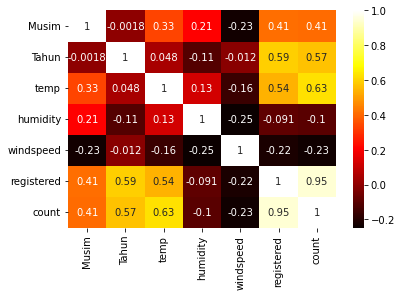

In [4]:
heatmap =sns.heatmap(df.corr(), cmap='hot', annot=True) 

In [5]:
X = df.copy()
y = X.pop("count")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()


# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [6]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
#mi_score = mi_scores.drop(["Tanggal",'registered']) # show a few features with their MI scores
mi_scores

registered    1.664060
Tanggal       0.904632
temp          0.390065
Bulan         0.366340
Tahun         0.276229
Musim         0.217992
weather       0.065541
windspeed     0.056137
humidity      0.045639
weekday       0.045336
holiday       0.011057
Name: MI Scores, dtype: float64

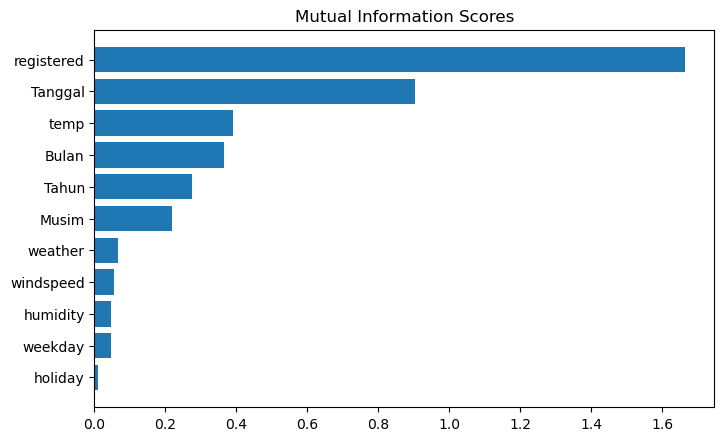

In [8]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

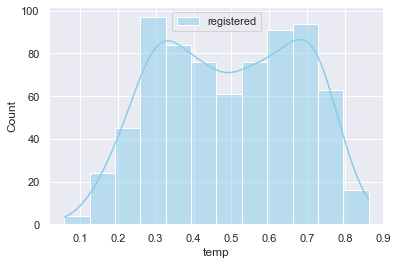

In [9]:
sns.set(style="darkgrid")

sns.histplot(data=df, x="temp", color="skyblue", label="registered", kde=True)

plt.legend() 
plt.show()

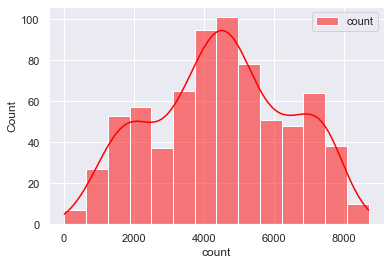

In [10]:
sns.set(style="darkgrid")

sns.histplot(data=df, x="count", color="red", label="count", kde=True)

plt.legend() 
plt.show()

Text(0.5, 1.0, 'Jumlah Sepeda yang disewa per Musim')

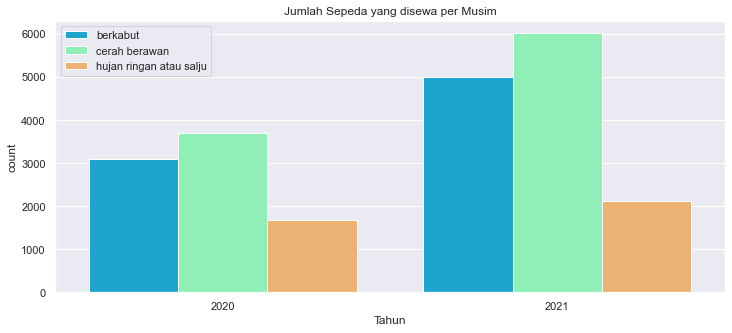

In [11]:
plt.figure(figsize=(12,5))
sns.barplot(x='Tahun',y='count',hue='weather',data=df,palette='rainbow', ci = None)
plt.legend()
plt.xlabel('Tahun')
plt.ylabel('count')
plt.title('Jumlah Sepeda yang disewa per Musim')

<Figure size 864x360 with 0 Axes>

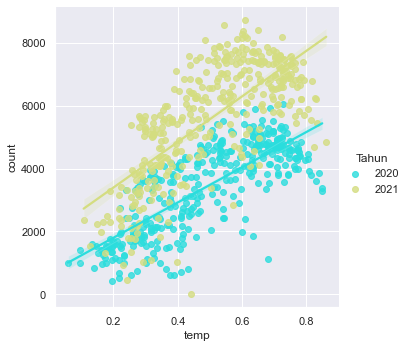

In [12]:
plt.figure(figsize=(12,5))
sns.lmplot(x='temp',y='count',hue = 'Tahun',palette = 'rainbow',data=df)

<AxesSubplot:xlabel='humidity', ylabel='count'>

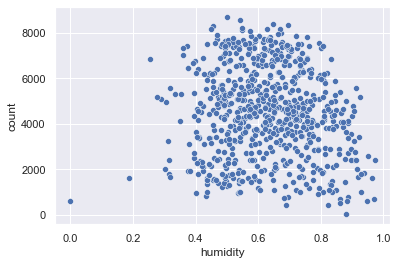

In [13]:
sns.scatterplot(x='humidity',y='count',data=df)

<AxesSubplot:xlabel='humidity', ylabel='count'>

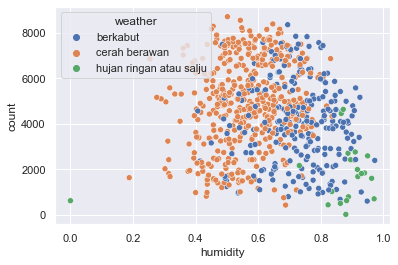

In [14]:
sns.scatterplot(x='humidity',y='count',hue= 'weather',data=df)

<AxesSubplot:xlabel='temp', ylabel='count'>

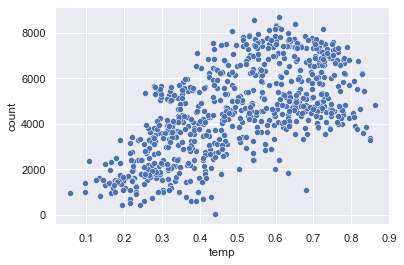

In [15]:
sns.scatterplot(x='temp',y='count',data=df)

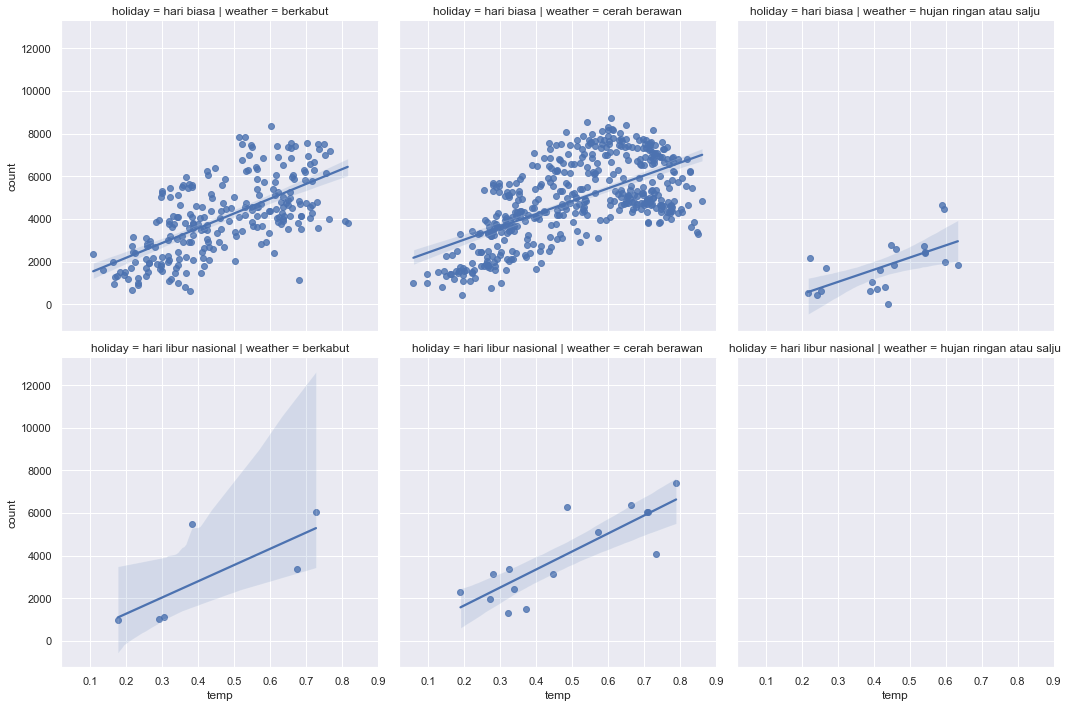

In [16]:
sns.lmplot(x = 'temp',y = 'count',row='holiday',col='weather',data=df)

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
x = sm.add_constant(X)
results = sm.OLS(y,x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1112.
Date:                Thu, 02 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:38:03   Log-Likelihood:                -5513.0
No. Observations:                 731   AIC:                         1.105e+04
Df Residuals:                     719   BIC:                         1.111e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.435e+05   8.17e+05     -0.910      0.3

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Multiple Regression Versi 1 

In [18]:
df.head()

,Tanggal,Musim,Tahun,Bulan,holiday,weekday,weather,temp,humidity,windspeed,registered,count
0,1/1/2020,1,2020,Januari,hari biasa,Wednesday,berkabut,0.344167,0.805833,0.160446,654,985
1,1/2/2020,1,2020,Januari,hari biasa,Thursday,berkabut,0.363478,0.696087,0.248539,670,801
2,1/3/2020,1,2020,Januari,hari biasa,Friday,cerah berawan,0.196364,0.437273,0.248309,1229,1349
3,1/4/2020,1,2020,Januari,hari biasa,Saturday,cerah berawan,0.200000,0.590435,0.160296,1454,1562
4,1/5/2020,1,2020,Januari,hari biasa,Sunday,cerah berawan,0.226957,0.436957,0.186900,1518,1600


In [19]:
X = df[['temp','humidity','windspeed']]
y = df['count']

### Train Test Split

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Creating Model

In [21]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [22]:
test_prediction = model.predict(X_test)
test_prediction

array([4186.16428178, 4614.01465605, 4796.83303339, 6470.70789785,
       4089.05614809, 3736.92465342, 3248.0140367 , 3444.89369485,
       6036.31460221, 4794.43940594, 6204.16990169, 3061.7589312 ,
       5046.943526  , 4987.07881443, 5061.72768016, 4201.37956759,
       6123.12287617, 3337.61830975, 3580.79267698, 5995.57486619,
       4485.1417339 , 4768.09155854, 2870.13854814, 5394.1558497 ,
       3368.16218936, 2526.55491157, 6435.0931689 , 4738.68056275,
       3512.07095489, 3506.80160693, 5475.06786826, 6011.38678038,
       4152.14227548, 5437.95352207, 3562.26567558, 2649.21500228,
       5050.90341223, 6515.77131785, 3567.97432785, 5951.03174128,
       2562.44220376, 4756.51115122, 3108.72090121, 4921.06511359,
       3721.7499304 , 3602.91781146, 4092.256245  , 5166.74457132,
       1892.11865316, 5348.89990396, 4948.2614031 , 3303.11044244,
       2889.0215738 , 5599.58545638, 5818.7500115 , 4422.49307763,
       2851.65458005, 4369.40590201, 4086.9141564 , 2936.33801

### Evaluasi Model

In [23]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
MAE = mean_absolute_error(y_test,test_prediction)
MSE = mean_squared_error(y_test,test_prediction)
RMSE = np.sqrt(MSE)
r2_score = r2_score(y_test, test_prediction)

In [25]:
print('MAE :', MAE)
print('MSE :', MSE)
print('RMSE :', RMSE)
print('R2 Score :', r2_score)

MAE : 1119.1186092609162
MSE : 1827837.5502481596
RMSE : 1351.975425164289
R2 Score : 0.4726118943603652


# Multiple Regression Versi 2 

In [26]:
df_multiple_versi_2 = df.copy()

In [27]:
df_multiple_versi_2

,Tanggal,Musim,Tahun,Bulan,holiday,weekday,weather,temp,humidity,windspeed,registered,count
0,1/1/2020,1,2020,Januari,hari biasa,Wednesday,berkabut,0.344167,0.805833,0.160446,654,985
1,1/2/2020,1,2020,Januari,hari biasa,Thursday,berkabut,0.363478,0.696087,0.248539,670,801
2,1/3/2020,1,2020,Januari,hari biasa,Friday,cerah berawan,0.196364,0.437273,0.248309,1229,1349
3,1/4/2020,1,2020,Januari,hari biasa,Saturday,cerah berawan,0.200000,0.590435,0.160296,1454,1562
4,1/5/2020,1,2020,Januari,hari biasa,Sunday,cerah berawan,0.226957,0.436957,0.186900,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
726,12/27/2021,1,2021,Desember,hari biasa,Monday,berkabut,0.254167,0.652917,0.350133,1867,2114
727,12/28/2021,1,2021,Desember,hari biasa,Tuesday,berkabut,0.253333,0.590000,0.155471,2451,3095
728,12/29/2021,1,2021,Desember,hari biasa,Wednesday,berkabut,0.253333,0.752917,0.124383,1182,1341
729,12/30/2021,1,2021,Desember,hari biasa,Thursday,cerah berawan,0.255833,0.483333,0.350754,1432,1796


In [38]:
df_multiple_versi_2['Tanggal'] = pd.to_datetime(df_multiple_versi_2['Tanggal'])

In [39]:
df_multiple_versi_2['Bulan'] = pd.to_datetime(df_multiple_versi_2['Tanggal']).dt.month

In [40]:
df_multiple_versi_2

,Tanggal,Musim,Tahun,Bulan,holiday,weekday,weather,temp,humidity,windspeed,registered,count
0,2020-01-01,1,2020,1,1,4,1,0.344167,0.805833,0.160446,654,985
1,2020-01-02,1,2020,1,1,5,1,0.363478,0.696087,0.248539,670,801
2,2020-01-03,1,2020,1,1,6,2,0.196364,0.437273,0.248309,1229,1349
3,2020-01-04,1,2020,1,1,7,2,0.200000,0.590435,0.160296,1454,1562
4,2020-01-05,1,2020,1,1,1,2,0.226957,0.436957,0.186900,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
726,2021-12-27,1,2021,12,1,2,1,0.254167,0.652917,0.350133,1867,2114
727,2021-12-28,1,2021,12,1,3,1,0.253333,0.590000,0.155471,2451,3095
728,2021-12-29,1,2021,12,1,4,1,0.253333,0.752917,0.124383,1182,1341
729,2021-12-30,1,2021,12,1,5,2,0.255833,0.483333,0.350754,1432,1796


In [41]:
df_multiple_versi_2['weekday'].unique()

array([4, 5, 6, 7, 1, 2, 3], dtype=int64)

In [33]:
df_multiple_versi_2['holiday'].unique()

array(['hari biasa', 'hari libur nasional'], dtype=object)

In [34]:
replace = {'weekday':{'Sunday':1,'Monday':2,'Tuesday':3,'Wednesday':4,'Thursday':5,'Friday':6,'Saturday':7}
          ,'holiday':{'hari biasa':1, 'hari libur nasional':2},
           'weather':{'berkabut':1,'cerah berawan':2,'hujan ringan atau salju':3}}

In [35]:
df_multiple_versi_2 = df.replace(replace)

In [42]:
df_multiple_versi_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Tanggal     731 non-null    datetime64[ns]
 1   Musim       731 non-null    int64         
 2   Tahun       731 non-null    int64         
 3   Bulan       731 non-null    int64         
 4   holiday     731 non-null    int64         
 5   weekday     731 non-null    int64         
 6   weather     731 non-null    int64         
 7   temp        731 non-null    float64       
 8   humidity    731 non-null    float64       
 9   windspeed   731 non-null    float64       
 10  registered  731 non-null    int64         
 11  count       731 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 68.7 KB


### Train Test Split

In [44]:
X = df_multiple_versi_2.drop(['Tanggal','count','registered'],axis=1)
y = df_multiple_versi_2['count']

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [46]:
X_train

,Musim,Tahun,Bulan,holiday,weekday,weather,temp,humidity,windspeed
53,1,2020,2,1,1,2,0.221739,0.423043,0.094113
117,2,2020,4,1,2,1,0.617500,0.700833,0.320908
708,4,2021,12,1,5,1,0.384167,0.905417,0.157975
60,1,2020,3,1,1,2,0.335000,0.449583,0.307833
72,1,2020,3,1,6,2,0.325217,0.496957,0.136926
...,...,...,...,...,...,...,...,...,...
75,1,2020,3,1,2,2,0.415000,0.602917,0.209579
599,3,2021,8,1,1,2,0.667500,0.677083,0.070283
575,3,2021,7,1,5,2,0.721667,0.623750,0.170396
337,4,2020,12,1,5,2,0.330833,0.775833,0.083958


In [47]:
y_train

53     1917
117    4058
708    3228
60     2134
72     2046
       ... 
75     2744
599    7375
575    6597
337    3485
523    7494
Name: count, Length: 511, dtype: int64

### Creating Model

In [49]:
from sklearn.linear_model import LinearRegression
model_multiple_versi_2 = LinearRegression()
model_multiple_versi_2.fit(X_train,y_train)

LinearRegression()

In [51]:
test_predictions_Versi_2 = model_multiple_versi_2.predict(X_test)
test_predictions_Versi_2

array([5033.01348839, 6312.81093144, 3534.54050392, 7388.04825051,
       3129.87742588, 3603.59811936, 2339.23155989, 3354.69415439,
       4732.57085709, 3456.31923035, 6990.85925468, 1397.32560369,
       3711.50913428, 4449.24434716, 3169.3187169 , 5759.24975263,
       7146.8377648 , 5180.99131179, 5483.11909198, 4382.38794064,
       4032.60760452, 4437.69020718, 1606.74997301, 6433.67981759,
       2015.78589614, 1154.2283532 , 5544.55386004, 5391.70745644,
       5280.22030282, 5397.36479504, 6117.5967068 , 7013.00469782,
       4770.78804875, 6066.56151363, 3046.68834233, 3463.20477896,
       4615.75737852, 4513.13273391, 3224.05390711, 4855.56171733,
       2821.65224873, 6334.56159916, 1840.15727834, 3590.71624321,
       3428.47879022, 3421.97565103, 3717.79792425, 5798.61479685,
       2615.91044602, 5098.66070454, 5730.31248862, 2366.42507652,
       3688.68804135, 4677.72477754, 6650.10479433, 3906.16914409,
       3533.15149969, 5118.02716242, 4436.30662942, 3722.27319

### Evaluasi Model

In [53]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
MAE = mean_absolute_error(y_test,test_predictions_Versi_2)
MSE = mean_squared_error(y_test,test_predictions_Versi_2)
RMSE = np.sqrt(MSE)
r2_score = r2_score(y_test,test_predictions_Versi_2)

In [54]:
print('MAE :', MAE)
print('MSE :', MSE)
print('RMSE :', RMSE)
print('R2 Score :', r2_score)

MAE : 609.8077665491242
MSE : 663538.5052990145
RMSE : 814.5787287297738
R2 Score : 0.8085484591991824


# Multiple Regresi Versi 3

In [57]:
df_multiple_versi_3 = df.copy()
df_multiple_versi_3

,Tanggal,Musim,Tahun,Bulan,holiday,weekday,weather,temp,humidity,windspeed,registered,count
0,1/1/2020,1,2020,Januari,hari biasa,Wednesday,berkabut,0.344167,0.805833,0.160446,654,985
1,1/2/2020,1,2020,Januari,hari biasa,Thursday,berkabut,0.363478,0.696087,0.248539,670,801
2,1/3/2020,1,2020,Januari,hari biasa,Friday,cerah berawan,0.196364,0.437273,0.248309,1229,1349
3,1/4/2020,1,2020,Januari,hari biasa,Saturday,cerah berawan,0.200000,0.590435,0.160296,1454,1562
4,1/5/2020,1,2020,Januari,hari biasa,Sunday,cerah berawan,0.226957,0.436957,0.186900,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
726,12/27/2021,1,2021,Desember,hari biasa,Monday,berkabut,0.254167,0.652917,0.350133,1867,2114
727,12/28/2021,1,2021,Desember,hari biasa,Tuesday,berkabut,0.253333,0.590000,0.155471,2451,3095
728,12/29/2021,1,2021,Desember,hari biasa,Wednesday,berkabut,0.253333,0.752917,0.124383,1182,1341
729,12/30/2021,1,2021,Desember,hari biasa,Thursday,cerah berawan,0.255833,0.483333,0.350754,1432,1796


In [58]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df['Bulan'] = pd.to_datetime(df['Tanggal']).dt.month

In [59]:
encoded = pd.get_dummies(df, columns = ['Tahun','holiday','weekday','weather'])
encoded

,Tanggal,Musim,Bulan,temp,humidity,windspeed,registered,count,Tahun_2020,Tahun_2021,...,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weather_berkabut,weather_cerah berawan,weather_hujan ringan atau salju
0,2020-01-01,1,1,0.344167,0.805833,0.160446,654,985,1,0,...,0,0,0,0,0,0,1,1,0,0
1,2020-01-02,1,1,0.363478,0.696087,0.248539,670,801,1,0,...,0,0,0,0,1,0,0,1,0,0
2,2020-01-03,1,1,0.196364,0.437273,0.248309,1229,1349,1,0,...,1,0,0,0,0,0,0,0,1,0
3,2020-01-04,1,1,0.200000,0.590435,0.160296,1454,1562,1,0,...,0,0,1,0,0,0,0,0,1,0
4,2020-01-05,1,1,0.226957,0.436957,0.186900,1518,1600,1,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2021-12-27,1,12,0.254167,0.652917,0.350133,1867,2114,0,1,...,0,1,0,0,0,0,0,1,0,0
727,2021-12-28,1,12,0.253333,0.590000,0.155471,2451,3095,0,1,...,0,0,0,0,0,1,0,1,0,0
728,2021-12-29,1,12,0.253333,0.752917,0.124383,1182,1341,0,1,...,0,0,0,0,0,0,1,1,0,0
729,2021-12-30,1,12,0.255833,0.483333,0.350754,1432,1796,0,1,...,0,0,0,0,1,0,0,0,1,0


### Train Test Split

In [60]:
X = encoded.drop(['Tanggal','count','registered'],axis=1)
y = encoded['count']

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [62]:
X_train

,Musim,Bulan,temp,humidity,windspeed,Tahun_2020,Tahun_2021,holiday_hari biasa,holiday_hari libur nasional,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weather_berkabut,weather_cerah berawan,weather_hujan ringan atau salju
53,1,2,0.221739,0.423043,0.094113,1,0,1,0,0,0,0,1,0,0,0,0,1,0
117,2,4,0.617500,0.700833,0.320908,1,0,1,0,0,1,0,0,0,0,0,1,0,0
708,4,12,0.384167,0.905417,0.157975,0,1,1,0,0,0,0,0,1,0,0,1,0,0
60,1,3,0.335000,0.449583,0.307833,1,0,1,0,0,0,0,1,0,0,0,0,1,0
72,1,3,0.325217,0.496957,0.136926,1,0,1,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1,3,0.415000,0.602917,0.209579,1,0,1,0,0,1,0,0,0,0,0,0,1,0
599,3,8,0.667500,0.677083,0.070283,0,1,1,0,0,0,0,1,0,0,0,0,1,0
575,3,7,0.721667,0.623750,0.170396,0,1,1,0,0,0,0,0,1,0,0,0,1,0
337,4,12,0.330833,0.775833,0.083958,1,0,1,0,0,0,0,0,1,0,0,0,1,0


In [63]:
y_train

53     1917
117    4058
708    3228
60     2134
72     2046
       ... 
75     2744
599    7375
575    6597
337    3485
523    7494
Name: count, Length: 511, dtype: int64

### Creating Model

In [64]:
from sklearn.linear_model import LinearRegression
model_multiple_versi_3 = LinearRegression()
model_multiple_versi_3 .fit(X_train,y_train)

LinearRegression()

In [66]:
test_predictions_versi_3  = model_multiple_versi_3.predict(X_test)
test_predictions_versi_3

array([5131.28886517, 6556.87844335, 3978.51803992, 6970.19358423,
       3303.72569846, 3302.98512377,  977.00382837, 3528.31026275,
       4404.58675696, 3876.80236805, 6717.70260157, 1566.78168021,
       4286.75627936, 4535.3909348 , 2986.96911914, 5752.19165697,
       7274.35209399, 5313.29633697, 5022.6800605 , 4539.1655714 ,
       3883.92568251, 4619.43656783, 1933.19533637, 6441.18176527,
       2286.37490455, 1188.74609219, 5361.92486012, 5134.52818442,
       4994.79842629, 5146.28220237, 6152.48942168, 7141.18274791,
       5105.03256278, 5830.38155628, 1365.70384803, 3242.45046009,
       4699.67955729, 3838.32798913, 1611.31038463, 5269.79227462,
       2821.90971033, 6076.72436976, 1834.59094746, 3658.56306887,
       1865.59432558, 3664.98716937, 3799.34435317, 6326.76896179,
       1102.42355156, 5170.98612243, 6038.1138522 , 2537.02499332,
       3555.20323785, 4154.44938399, 7016.91806325, 4241.10247821,
       3131.61831103, 5106.68476715, 4132.20213089, 4012.56311

### Evaluating Model 

In [67]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
MAE = mean_absolute_error(y_test,test_predictions_versi_3)
MSE = mean_squared_error(y_test,test_predictions_versi_3)
RMSE = np.sqrt(MSE)
r2_score = r2_score(y_test, test_predictions_versi_3)

In [68]:
print('MAE :', MAE)
print('MSE :', MSE)
print('RMSE :', RMSE)
print('R2 Score :', r2_score)

MAE : 583.2850243407611
MSE : 602005.1246708608
RMSE : 775.8898921050982
R2 Score : 0.8263027574620005


# SARIMA Model 

In [69]:
df_sarima = df.copy()

In [71]:
df_sarima = df[['Tanggal','count']]
df_sarima.index = pd.to_datetime(df_sarima['Tanggal'])
df_sarima.drop(columns='Tanggal',inplace=True)
df_sarima.head()

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,count
Tanggal,
2020-01-01,985
2020-01-02,801
2020-01-03,1349
2020-01-04,1562
2020-01-05,1600


In [73]:
df_sarima = df_sarima.asfreq(pd.infer_freq(df_sarima.index))
df_sarima

,count
Tanggal,
2020-01-01,985
2020-01-02,801
2020-01-03,1349
2020-01-04,1562
2020-01-05,1600
...,...
2021-12-27,2114
2021-12-28,3095
2021-12-29,1341


Text(0, 0.5, 'Jumlah Penyewaan')

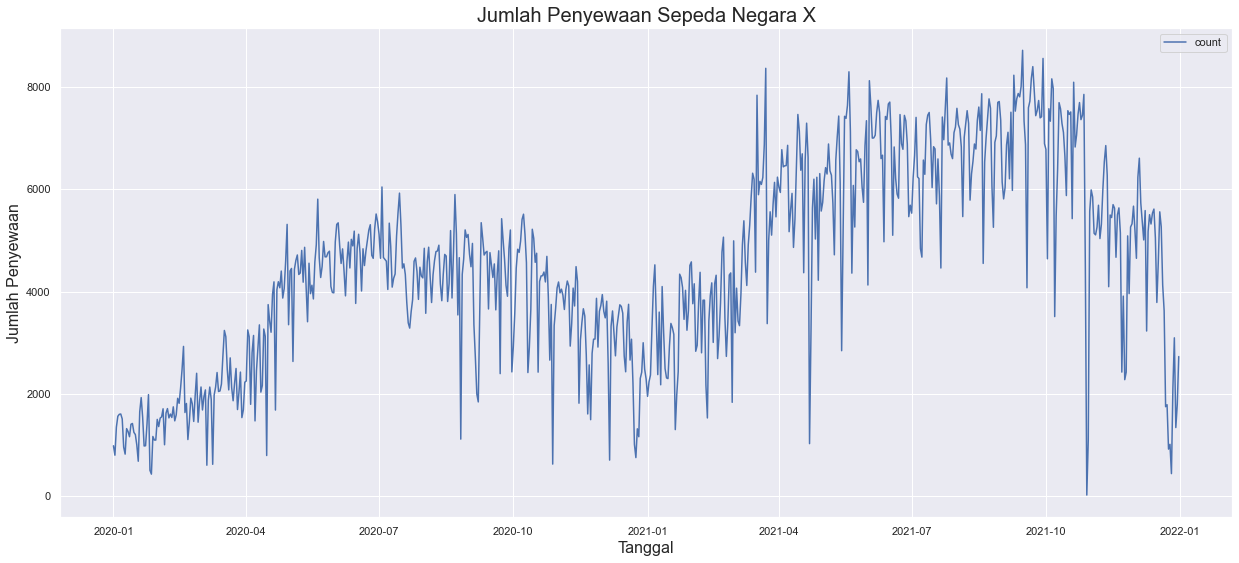

In [74]:
plt.figure(figsize=(21,9))
sns.lineplot(data=df_sarima)
plt.title('Jumlah Penyewaan Sepeda Negara X',fontsize=20)
plt.xlabel('Tanggal',fontsize=16)
plt.ylabel('Jumlah Penyewaan',fontsize=16)

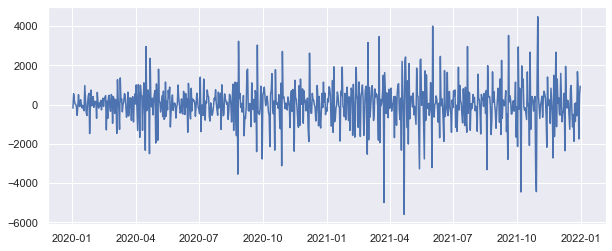

In [75]:
first_diff = df_sarima.diff()[1:]
plt.figure(figsize=(10,4))
plt.plot(first_diff)

In [76]:
result = adfuller(first_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.778809
p-value: 0.000000


In [77]:
first_diff

,count
Tanggal,
2020-01-02,-184.0
2020-01-03,548.0
2020-01-04,213.0
2020-01-05,38.0
2020-01-06,6.0
...,...
2021-12-27,1673.0
2021-12-28,981.0
2021-12-29,-1754.0


### Mencari nilai p (ACF)

Diambil nilai p = 1

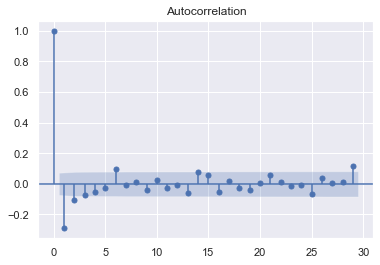

In [78]:
acf_plot = plot_acf(first_diff)

### Mencari nilai q (PACF)

Diambil nilai q = 1

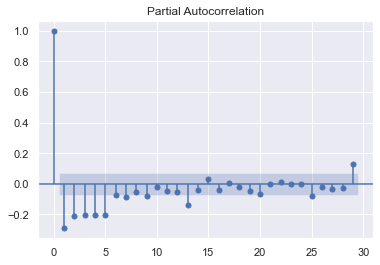

In [80]:
pacf_plot = plot_pacf(first_diff)

In [82]:
# 1,0,1 ARIMA Model
model = ARIMA(first_diff, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                  730
Model:                     ARMA(1, 1)   Log Likelihood               -6021.891
Method:                       css-mle   S.D. of innovations            924.804
Date:                Thu, 02 Jun 2022   AIC                          12051.781
Time:                        14:20:53   BIC                          12070.153
Sample:                    01-02-2020   HQIC                         12058.869
                         - 12-31-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1300      5.919      0.360      0.719      -9.471      13.731
ar.L1.count     0.3592      0.042      8.497      0.000       0.276       0.442
ma.L1.count    -0.8904      0.019    -46.490    

In [87]:
model= SARIMAX(df_sarima,order=(1, 1, 1),seasonal_order=(1,1,1,90))
results=model.fit()

In [88]:
from pandas.tseries.offsets import DateOffset
pred_date=[df_sarima.index[-1]+ DateOffset(days=x)for x in range(0,730)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=df_sarima.columns)

In [89]:
pred = pd.concat([df_sarima,pred_date])
pred

,count
2020-01-01,985
2020-01-02,801
2020-01-03,1349
2020-01-04,1562
2020-01-05,1600
...,...
2023-12-26,NaN
2023-12-27,NaN
2023-12-28,NaN
2023-12-29,NaN


<AxesSubplot:>

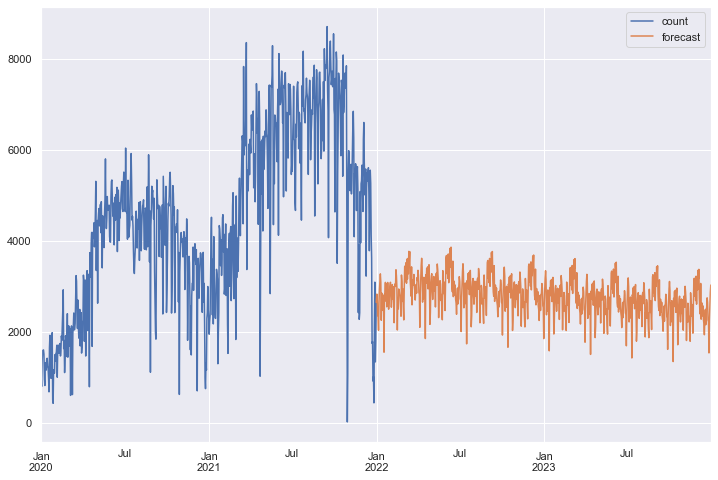

In [90]:
forecast = pred.copy()
forecast['forecast'] = results.predict(start = 730, end = 1460, dynamic= True)  
forecast.iloc[730]
forecast[['count', 'forecast']].plot(figsize=(12, 8))